In [7]:
%matplotlib notebook
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

import sys
sys.path.append('/home/msj/mobi/')
import mobi as mobi
from mobi_system_data import *

import cartopy.crs as ccrs

from matplotlib import cm
from numpy import linspace
import vanweather

In [3]:
df = prep_sys_df('/data/mobi/data/Mobi_System_Data.csv')

In [4]:
stationdf = pd.read_json('https://data.mikejarrett.ca/mobi/data/stations_df.json')
df = mobi.add_station_coords(df,stationdf)

In [6]:
idx24 = np.array(df['Membership Type']=='24 Hour')
idx365 = np.array(df['Membership Type'].str.contains('365.+Standard'))
idx365p = np.array(df['Membership Type'].str.contains('365.+Plus'))
idx365all = np.array(df['Membership Type'].str.contains('365'))
idx90 = np.array(df['Membership Type'].str.contains('90'))
idxvcp = np.array(df['Membership Type'].str.contains('Vancity'))



idx2018 = np.array(df.Departure.map(lambda x:x.year == 2018))
idx2017 = np.array(df.Departure.map(lambda x:x.year == 2017))

idxot = np.array(df['Duration (min.)'].map(lambda x:x>30))

idxstop = np.array(df['Number of stopovers'].map(lambda x:x>0))

mean_speed = df['average speed (km/h)'].mean()
std_speed = df['average speed (km/h)'].std()
idxfast = np.array(df['average speed (km/h)'].map(lambda x: x>mean_speed+std_speed))
idxslow = np.array(df['average speed (km/h)'].map(lambda x: x<mean_speed-std_speed))

In [10]:
wdf = vanweather.get_weather_range('2017-01','2018-12')

In [85]:
rainy_days = wdf[wdf['Total Precipmm']>5].index

rainy_days

DatetimeIndex(['2017-01-08', '2017-01-16', '2017-01-17', '2017-01-18',
               '2017-01-19', '2017-01-22', '2017-02-03', '2017-02-04',
               '2017-02-09', '2017-02-14',
               ...
               '2018-12-13', '2018-12-16', '2018-12-17', '2018-12-18',
               '2018-12-20', '2018-12-22', '2018-12-23', '2018-12-26',
               '2018-12-28', '2018-12-29'],
              dtype='datetime64[ns]', name='Day', length=175, freq=None)

In [86]:
df['Departure date'] = df['Departure'].dt.strftime("%Y-%m-%d")

rainy_days = [x.strftime('%Y-%m-%d') for x in rainy_days]

idxrain = np.array(df['Departure date'].isin(rainy_days).values)

In [128]:
condf = make_con_df(df)

In [131]:
condf.sort_values('trips',ascending=False).head()

,stations coords,stations,trips,start coords,stop coords,start station,stop station
13965,"((49.29534, -123.150433), (49.298657, -123.121...","(Stanley Park - Second Beach North, Stanley Pa...",8124,"(49.29534, -123.150433)","(49.298657, -123.121176)",Stanley Park - Second Beach North,Stanley Park - Totem Poles
13968,"((49.297933, -123.130758), (49.298657, -123.12...","(Stanley Park - Information Booth, Stanley Par...",7250,"(49.297933, -123.130758)","(49.298657, -123.121176)",Stanley Park - Information Booth,Stanley Park - Totem Poles
13964,"((49.29534, -123.150433), (49.297933, -123.130...","(Stanley Park - Information Booth, Stanley Par...",5156,"(49.29534, -123.150433)","(49.297933, -123.130758)",Stanley Park - Information Booth,Stanley Park - Second Beach North
13967,"((49.297933, -123.130758), (49.297933, -123.13...","(Stanley Park - Information Booth, Stanley Par...",4621,"(49.297933, -123.130758)","(49.297933, -123.130758)",Stanley Park - Information Booth,Stanley Park - Information Booth
13130,"((49.282224, -123.132778), (49.285836, -123.12...","(Bute & Davie, Bute & Robson)",4456,"(49.282224, -123.132778)","(49.285836, -123.127265)",Bute & Davie,Bute & Robson


In [158]:
def make_con_plot(df,title="",subtitle="",lim=200,ntrips=True):
    
    totaltrips = len(df)
    condf = make_con_df(df)
    
    start = 0.0
    stop = 1.0
    number_of_lines = len(condf)
    cm_subsection = linspace(start, stop, number_of_lines) 
    colors = [ cm.winter(x) for x in cm_subsection ]
    
    
    plot = mobi.geomobi.GeoPlot()
    plot.addgeo('/home/msj/shapes/bikeways.shp',facecolor="none",edgecolor='gray',zorder=95,alpha=0.1)
    plot.addgeo('/home/msj/shapes/shoreline2002.shp',facecolor='#ffffff',zorder=1)    
    
    plot.ax.text(plot.right,plot.top-500,title,color=plot.fg_color,size=18,alpha=0.8,horizontalalignment='right')
    plot.ax.text(plot.right,plot.top-1000,subtitle,color=plot.fg_color,size=18,alpha=0.8,horizontalalignment='right')
    if ntrips:
        plot.ax.text(plot.right,plot.top-1500,"trips = {:,}".format(len(df)),color=plot.fg_color,size=12,alpha=0.8,horizontalalignment='right')
    
    for i,route in condf.sort_values('trips',ascending=False).iloc[:lim].iterrows():
        [y1,x1] = route['start coords'] 
        [y2,x2] = route['stop coords']
        trips = route['trips']
        maxtrip = condf['trips'].max()
        #plot.ax.arrow(x1,y1,x2-x1,y2-y1,transform=ccrs.PlateCarree(),length_includes_head=False,alpha=0.1,width=trips/100000)
        line, = plot.ax.plot([x1,x2],[y1,y2],transform=ccrs.PlateCarree(),
                             alpha=0.5,#trips/maxtrip,
                             linewidth=10*trips/maxtrip,
                             color=plot.fg_color2) 

        line.set_solid_capstyle('round')
    
    # Make invisible lines to use in legend
    p1, = plot.ax.plot([-123,-123.1],[49,49.1],linewidth=10,color=plot.fg_color2)
    p2, = plot.ax.plot([-123,-123.1],[49,49.1],linewidth=5,color=plot.fg_color2)
    
    plot.ax.legend([p1,p2],
                   ["{:.02}%".format(100*maxtrip/totaltrips),"{:.02}%".format(100*maxtrip*0.5/totaltrips)],
                   loc=2,
                   frameon=False,
                   title='Percent of all trips')
    
    return plot

<IPython.core.display.Javascript object>


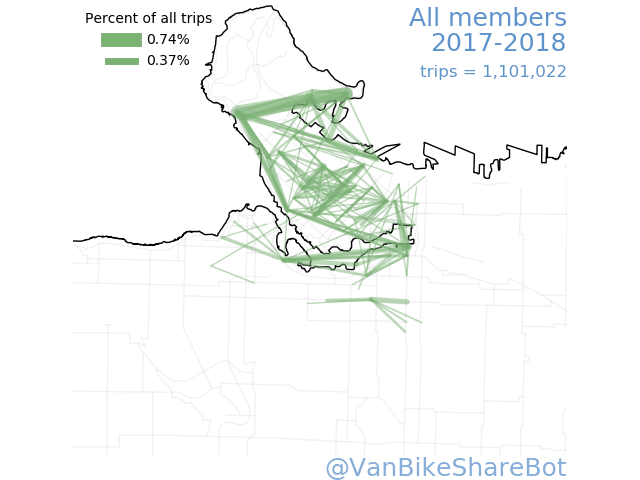

In [159]:
make_con_plot(df,title="All members",subtitle="2017-2018",lim=200)

<IPython.core.display.Javascript object>


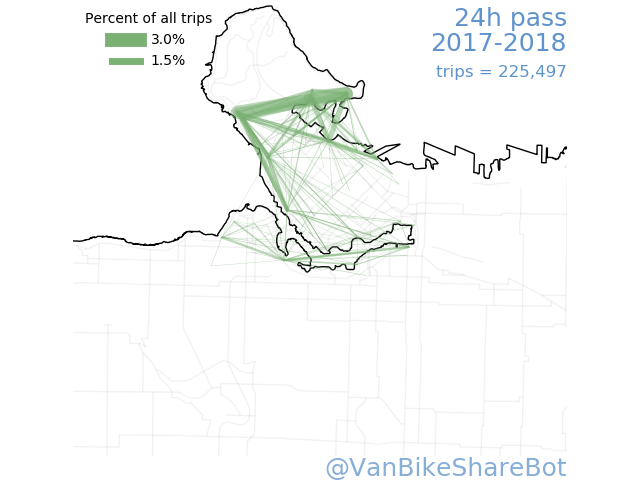

In [160]:
make_con_plot(df.iloc[idx24],title="24h pass",subtitle="2017-2018",lim=200)

<IPython.core.display.Javascript object>


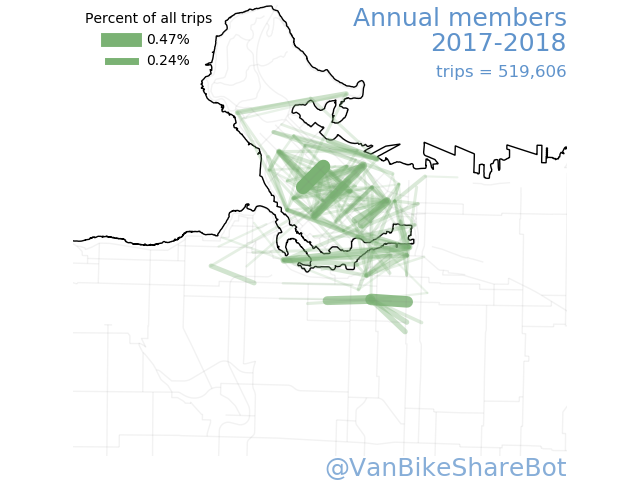

In [154]:
make_con_plot(df.iloc[idx365all],title="Annual members",subtitle="2017-2018",lim=200)

<IPython.core.display.Javascript object>


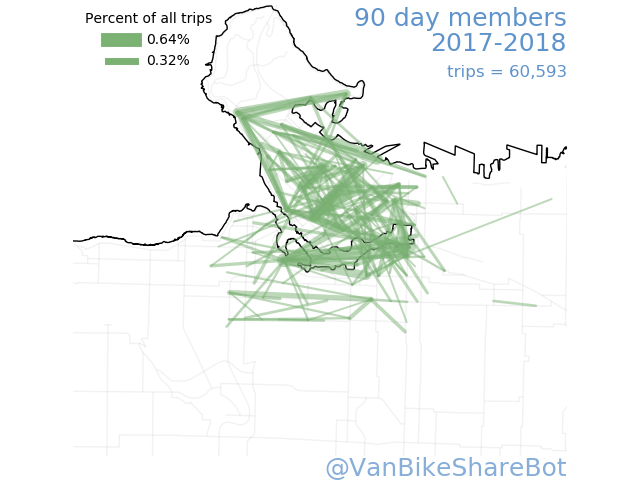

In [161]:
make_con_plot(df.iloc[idx90],title="90 day members",subtitle="2017-2018",lim=200)

<IPython.core.display.Javascript object>


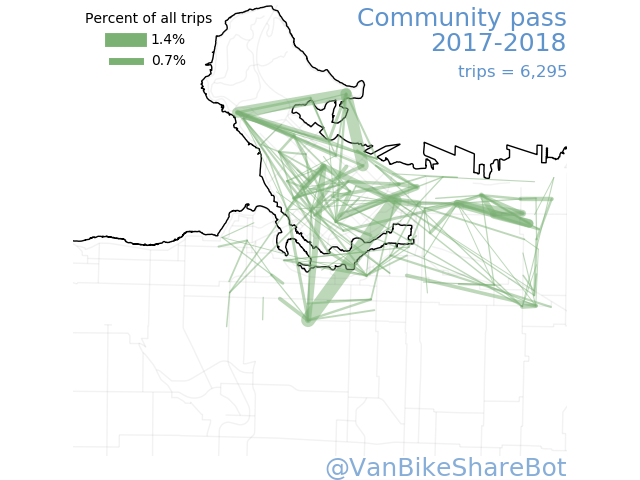

In [162]:
make_con_plot(df.iloc[idxvcp],title="Community pass",subtitle="2017-2018",lim=200)

<IPython.core.display.Javascript object>


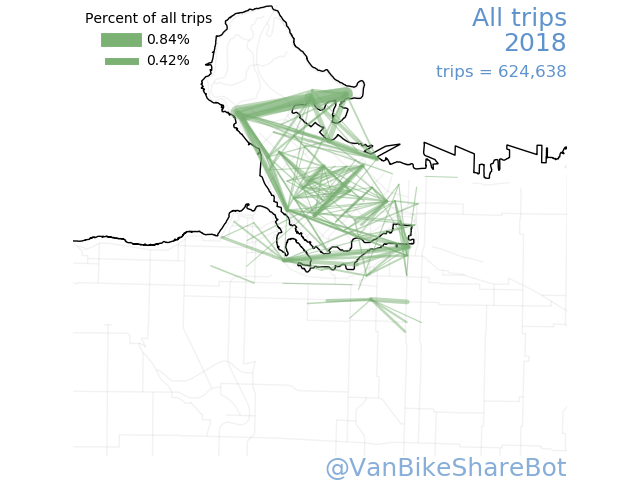

In [163]:
make_con_plot(df.iloc[idx2018],title="All trips",subtitle="2018",lim=200)

<IPython.core.display.Javascript object>


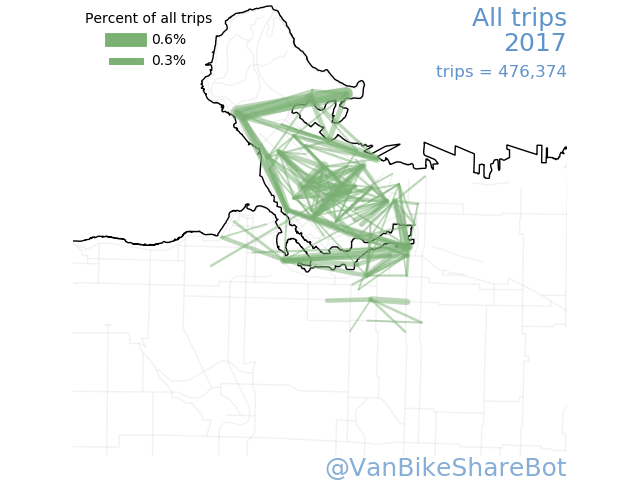

In [164]:
make_con_plot(df.iloc[idx2017],title="All trips",subtitle="2017",lim=200)

<IPython.core.display.Javascript object>


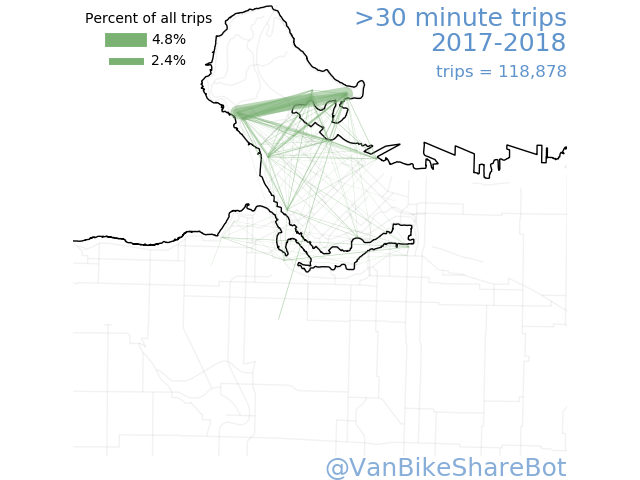

In [165]:
make_con_plot(df.iloc[idxot],title=">30 minute trips",subtitle="2017-2018",lim=200)

<IPython.core.display.Javascript object>


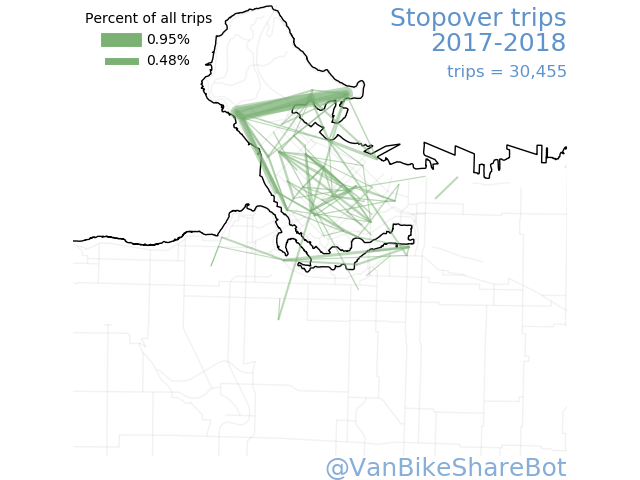

In [166]:
make_con_plot(df.iloc[idxstop],title="Stopover trips",subtitle="2017-2018",lim=200)

<IPython.core.display.Javascript object>


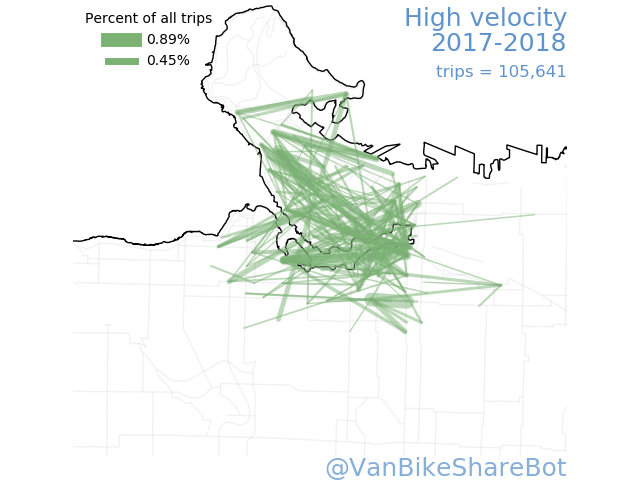

In [167]:
make_con_plot(df.iloc[idxfast],title="High velocity",subtitle="2017-2018",lim=200)

<IPython.core.display.Javascript object>


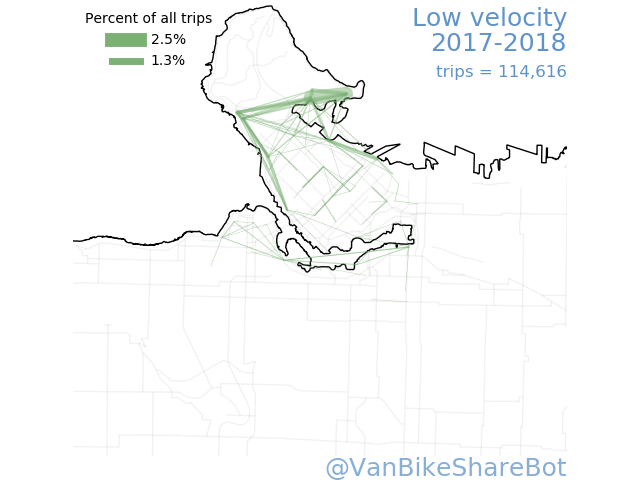

In [168]:
make_con_plot(df.iloc[idxslow],title="Low velocity",subtitle="2017-2018",lim=200)

<IPython.core.display.Javascript object>


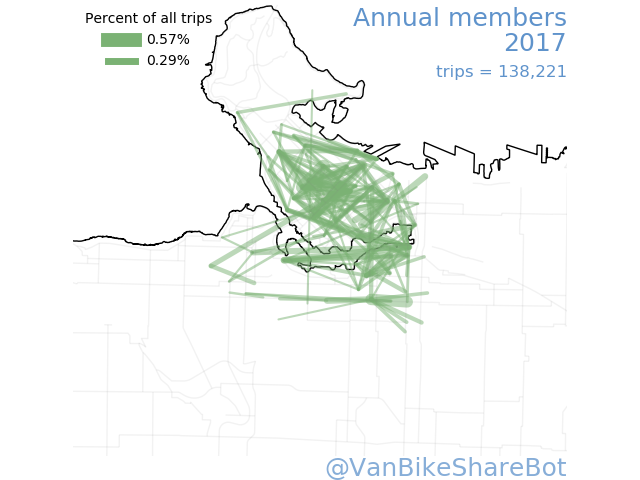

In [169]:
make_con_plot(df.iloc[idx2017 & idx365all],subtitle="2017",title="Annual members")

<IPython.core.display.Javascript object>


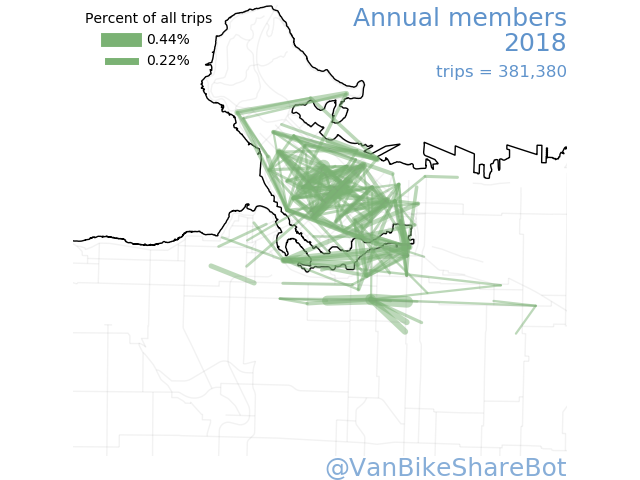

In [170]:
make_con_plot(df.iloc[idx2018 & idx365all],title="Annual members",subtitle="2018")

# Top pairs of stations

In [ ]:
condf.iloc[condf['trips'].idxmax()]

In [ ]:
condf.sort_values('trips',ascending=False).set_index('trips')[['start station','stop station']]

In [ ]:
line.set_solid_joinstyle?

In [ ]:
line

In [ ]:
df